In [1]:
import torch
import pickle
import numpy as np
from simulator_lstm import CustomEnv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')




model_path = '../data/VesselSimulator/lstm_model_ar5.pth'
scaler_path = '../data/VesselSimulator/scaler.pkl'
start_trip_path = '../data/VesselSimulator/start_trip.pkl'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = CustomEnv(model_path, start_trip_path, scaler_path = scaler_path, device = device)
with open(scaler_path, 'rb') as f:
        content = pickle.load(f)
        scaler = content['scaler']
print(env.reset())
state, reward, done, info = env.step([0.5, 0.5, 0])
print(f'The reward is {reward}')

tensor([0.8363, 0.0125, 1.0000, 0.6673, 0.7637, 0.4935, 0.1570, 0.0611, 0.1071,
        0.0000, 0.9932, 0.0000, 0.0037, 0.6381, 0.8875, 0.0400, 0.0000, 0.9769,
        0.4430, 0.8363, 0.9157, 0.9965])
The reward is -0.25818517804145813


In [37]:
# Step 1: choose the test data
test_path = '../data/VesselSimulator/data_test.pkl'
with open(test_path, 'rb') as f:
    content = pickle.load(f)
    # SELECT X2 for both if you want the data that has never been trained on
    # or X1 for the data that has been trained on
    X1_test_state = content['X2'][0] 
    X1_test_target = content['X2'][1]

# remove the first column (done flag) from X1_test_state
X1_test_state = X1_test_state[:, :, 1:]

# Step 2; for Full autoregressive, no measurement (AR = -1) or non-autoregressive (AR = 0) or for n-step prediction (AR = n)
AR = 10


In [43]:
# Select each trip, then go over each time step, and apply the step
X1_test_state_pred = np.zeros((X1_test_state.shape[0], X1_test_state.shape[1], 24)) # 22 states + 1 done flag + 1 reward
X1_test_target_pred = np.zeros((X1_test_state.shape[0], X1_test_state.shape[1], 6)) # SFC, SOG, LAT, LON, 'EAT', 'cf_SFC'
X1_test_target_pred_horizon = np.zeros_like(X1_test_target_pred)
for i in range(len(X1_test_state)):
    current_trip = X1_test_state[i] 
    env.reset(current_trip[0][:22]) # without the done flag
    for j in range(len(current_trip)):
        horizon = 0
        if AR == 0:
            state, reward, done, info = env.step(current_trip[j][:3],current_trip[j][3:22]) # NAR
        elif AR == -1:
            state, reward, done, info = env.step(current_trip[j][:3]) # AR
        else:
            state, reward, done, info = env.step(current_trip[j][:3],current_trip[j][3:22]) # NAR
            while AR > horizon and j+horizon+1 < len(current_trip):
                state_ar, reward_ar, done_ar, info_ar = env.step(current_trip[j+horizon+1][:3]) # AR
                horizon += 1

        X1_test_state_pred[i][j] = np.concatenate([[info['state_org'][k] for k in info['state_org'].keys()], [done], [reward]])
        X1_test_target_pred[i][j] = np.array([info['output_org']['SFC'], info['output_org']['SOG'], info['output_org']['LAT'], info['output_org']['LON'], info['output_org']['EAT'], info['output_org']['cf_SFC']])
        if AR > 0:
            X1_test_target_pred_horizon[i][j] = np.array([info_ar['output_org']['SFC'], info_ar['output_org']['SOG'], info_ar['output_org']['LAT'], info_ar['output_org']['LON'], info_ar['output_org']['EAT'], info_ar['output_org']['cf_SFC']])

        if done:
            break





# concatenate X1_test_state and X1_test_target on last axis to do inverse_transform
X1_test = np.concatenate([X1_test_state, X1_test_target], axis=2)
# now inverse transform
X1_test_org = scaler.inverse_transform(X1_test.reshape(-1,  X1_test.shape[2]))
# reshape back to original shape
X1_test_org = X1_test_org.reshape(X1_test.shape[0], X1_test.shape[1], X1_test.shape[2])
# now compare the original and predicted values by plotting


X1_test_org = X1_test_org[:, :-10, :]
X1_test_target_pred = X1_test_target_pred[:, :-10, :]
X1_test_state_pred = X1_test_state_pred[:, :-10, :]
X1_test_target_pred_horizon = np.concatenate((np.repeat(X1_test_target_pred_horizon[:,0:1, :], repeats = abs(AR), axis = 1), X1_test_target_pred_horizon), axis = 1)
X1_test_target_pred_horizon = X1_test_target_pred_horizon[:, :-10, :]



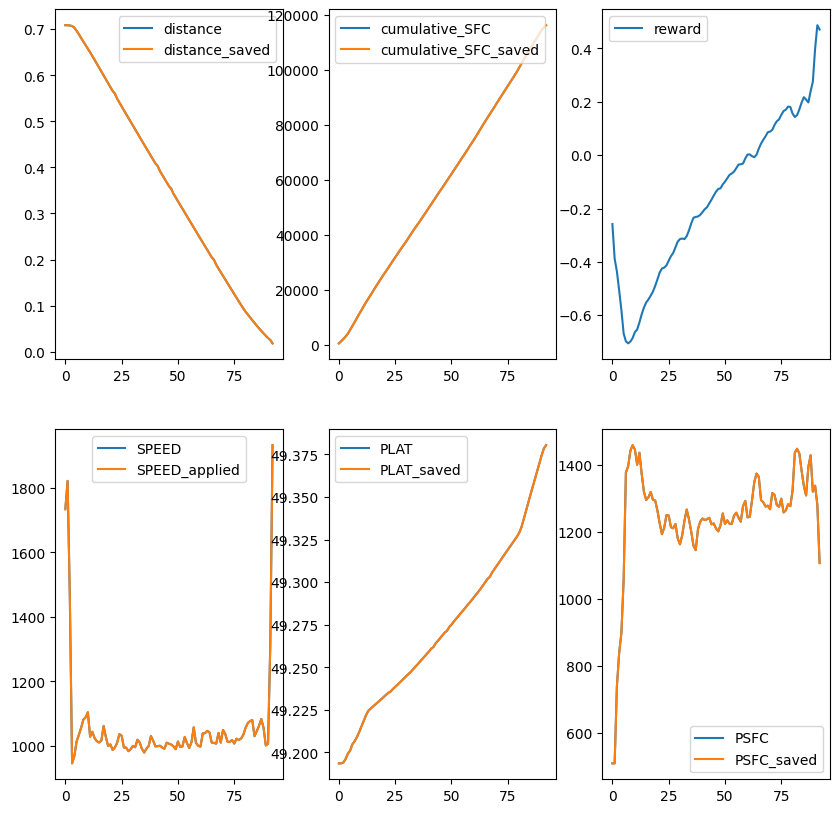

In [39]:
# select a trip 
id = 2
plt.figure(figsize=(10, 10))
# compare ouput values
ax = plt.subplot(2, 3, 1)
ax.plot(X1_test_org[id, :, 10], label='distance')
ax.plot(X1_test_state_pred[id, :, 10], label='distance_saved')  
ax.legend()
ax = plt.subplot(2, 3, 2)
ax.plot(X1_test_org[id, :, 12], label='cumulative_SFC')
ax.plot(X1_test_state_pred[id, :, 12], label='cumulative_SFC_saved')
ax.legend()
ax = plt.subplot(2, 3, 3)
ax.plot(X1_test_state_pred[id, :, -1], label='reward')
ax.legend()
ax = plt.subplot(2, 3, 4)
ax.plot(X1_test_org[id, :, 0], label='SPEED')
ax.plot(X1_test_state_pred[id, :, 0], label='SPEED_applied')
ax.legend()
ax = plt.subplot(2, 3, 5)
ax.plot(X1_test_org[id, :, 20], label='PLAT')
ax.plot(X1_test_state_pred[id, :, 20], label='PLAT_saved')
ax.legend()
ax = plt.subplot(2, 3, 6)
ax.plot(X1_test_org[id, :, 18], label='PSFC')
ax.plot(X1_test_state_pred[id, :, 18], label='PSFC_saved')
ax.legend()
plt.show()

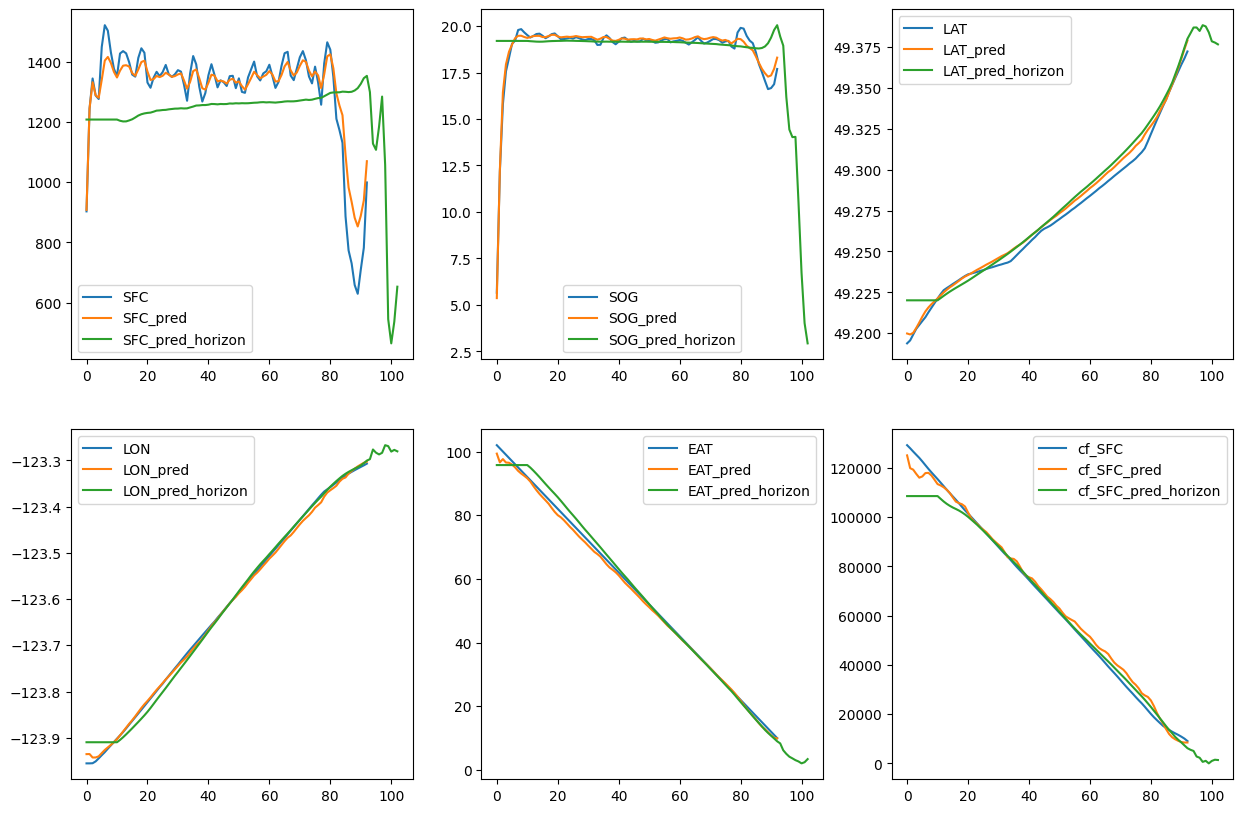

In [44]:
# select a trip 
id = 0
plt.figure(figsize=(15, 10))
# compare ouput values
ax = plt.subplot(2, 3, 1)
ax.plot(X1_test_org[id, :, 22], label='SFC')
ax.plot(X1_test_target_pred[id, :, 0], label='SFC_pred')
if AR > 0:
    ax.plot(X1_test_target_pred_horizon[id, :, 0], label='SFC_pred_horizon')  
ax.legend()
ax = plt.subplot(2, 3, 2)
ax.plot(X1_test_org[id, :, 23], label='SOG')
ax.plot(X1_test_target_pred[id, :, 1], label='SOG_pred')
if AR > 0:
    ax.plot(X1_test_target_pred_horizon[id, :, 1], label='SOG_pred_horizon')
ax.legend()
ax = plt.subplot(2, 3, 3)
ax.plot(X1_test_org[id, :, 24], label='LAT')
ax.plot(X1_test_target_pred[id, :, 2], label='LAT_pred')
if AR > 0:
    ax.plot(X1_test_target_pred_horizon[id, :, 2], label='LAT_pred_horizon')
ax.legend()
ax = plt.subplot(2, 3, 4)
ax.plot(X1_test_org[id, :, 25], label='LON')
ax.plot(X1_test_target_pred[id, :, 3], label='LON_pred')
if AR > 0:
    ax.plot(X1_test_target_pred_horizon[id, :, 3], label='LON_pred_horizon')
ax.legend()
ax = plt.subplot(2, 3, 5)
ax.plot(X1_test_org[id, :, 26], label='EAT')
ax.plot(X1_test_target_pred[id, :, 4], label='EAT_pred')
if AR > 0:
    ax.plot(X1_test_target_pred_horizon[id, :, 4], label='EAT_pred_horizon')
ax.legend()
ax = plt.subplot(2, 3, 6)
ax.plot(X1_test_org[id, :, 27], label='cf_SFC')
ax.plot(X1_test_target_pred[id, :, 5], label='cf_SFC_pred')
if AR > 0:
    ax.plot(X1_test_target_pred_horizon[id, :, 5], label='cf_SFC_pred_horizon')
ax.legend()
plt.show()

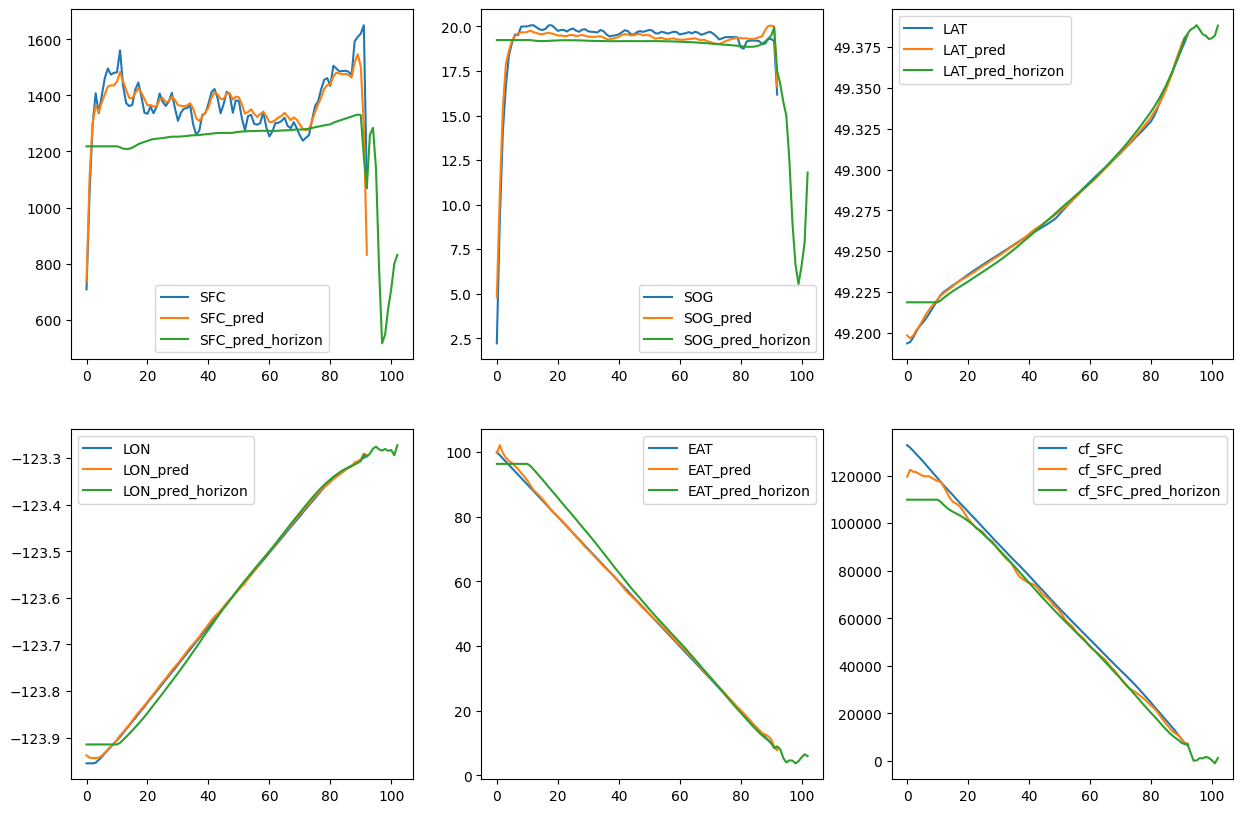

In [45]:
# select a trip 
id = 4
plt.figure(figsize=(15, 10))
# compare ouput values
ax = plt.subplot(2, 3, 1)
ax.plot(X1_test_org[id, :, 22], label='SFC')
ax.plot(X1_test_target_pred[id, :, 0], label='SFC_pred')
if AR > 0:
    ax.plot(X1_test_target_pred_horizon[id, :, 0], label='SFC_pred_horizon')  
ax.legend()
ax = plt.subplot(2, 3, 2)
ax.plot(X1_test_org[id, :, 23], label='SOG')
ax.plot(X1_test_target_pred[id, :, 1], label='SOG_pred')
if AR > 0:
    ax.plot(X1_test_target_pred_horizon[id, :, 1], label='SOG_pred_horizon')
ax.legend()
ax = plt.subplot(2, 3, 3)
ax.plot(X1_test_org[id, :, 24], label='LAT')
ax.plot(X1_test_target_pred[id, :, 2], label='LAT_pred')
if AR > 0:
    ax.plot(X1_test_target_pred_horizon[id, :, 2], label='LAT_pred_horizon')
ax.legend()
ax = plt.subplot(2, 3, 4)
ax.plot(X1_test_org[id, :, 25], label='LON')
ax.plot(X1_test_target_pred[id, :, 3], label='LON_pred')
if AR > 0:
    ax.plot(X1_test_target_pred_horizon[id, :, 3], label='LON_pred_horizon')
ax.legend()
ax = plt.subplot(2, 3, 5)
ax.plot(X1_test_org[id, :, 26], label='EAT')
ax.plot(X1_test_target_pred[id, :, 4], label='EAT_pred')
if AR > 0:
    ax.plot(X1_test_target_pred_horizon[id, :, 4], label='EAT_pred_horizon')
ax.legend()
ax = plt.subplot(2, 3, 6)
ax.plot(X1_test_org[id, :, 27], label='cf_SFC')
ax.plot(X1_test_target_pred[id, :, 5], label='cf_SFC_pred')
if AR > 0:
    ax.plot(X1_test_target_pred_horizon[id, :, 5], label='cf_SFC_pred_horizon')
ax.legend()
plt.show()